# Titanic - binary classification

### 1. Take a look at the data

Before jumping into training models, we first need to take a peek at the data to find out how it looks.

Things to find out: 

* What are the predictors and response variables?

* Numerical/Categorical variables?

* Any variable with missing data?

-----

From the data description, we know that,

* Survival: response variable. 0=No, 1=Yes

* Pclass: ticket class. 1=1st, 2=2nd, 3=3rd

* Sex: sex. male, female

* Age: age in years

* sibsp: number of sibilings/spouses aboard

* parch: number of parents/children aboard

* ticket: ticket number

* fare: passenger fare

* cabin: cabin number

* embardked: port of embarkation. C=Cherbourg, Q=Queenstown, S=Southhampton

---

So Survived is our response variable, and there are a number of categorical variables(pclass, sex, embarked)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

titanic = pd.read_csv("train.csv")
titanic.head(5) # prints first 5 entries


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are some data cleaning to do. For example, all characters must be removed in 'Ticket', Sex and Embarked could be one-hot encoded. 

But first, let's check if there are any missing values.

In [3]:
print(titanic.count()) # shows total counts for each column

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


It looks like the column 'Cabin' has a lot of missing values. Since it does not even have half of the total entries(891), I decided to eliminate this column.

For Age and Embarked, we must think of some other methods.

For Embarked, let's see which row contains the missing values.

In [4]:
print(titanic[titanic.Embarked.isnull()].index.tolist()) # shows the indices of the missing values
pd.DataFrame(titanic, index = [61,829])

[61, 829]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We don't know immediately where they might had embarked from but we can guess the Pclass, fare and the ticket number may have some association with 'embarked'.

We are going to extract entries that satisfy three conditions:

* Pclass = First class since both of the missing cases have Pclass=1

* Fare over 70

* Ticket number starts with 1

In [5]:
titanic["Ticket"] = titanic["Ticket"].str.replace(r'\D', '') # removes any non-digit characters 
titanic["Ticket"] = titanic["Ticket"].str.replace(r' ', '')
# titanic["Ticket"] = titanic["Ticket"].replace('', 0) # convert any missing value to 0
# temp = [0] * len(titanic["Ticket"])
# for i in range(len(titanic["Ticket"])):
#     temp[i] = int(titanic["Ticket"][i])
# titanic["Ticket"] = temp



In [6]:
temp = pd.DataFrame(titanic, columns=["Ticket", "Fare", "Embarked","Pclass"])
Pclass_1 = temp["Pclass"] == 1
fare_80 = temp["Fare"] >= 75
ticket_1 = temp["Ticket"].str[:1] == "1" 
subset_temp = titanic[Pclass_1 & fare_80 & ticket_1]
subset_temp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,17569,146.5208,B78,C
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,17604,82.1708,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,17572,76.7292,D33,C
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
820,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
835,836,1,1,"Compton, Miss. Sara Rebecca",female,39.0,1,1,17756,83.1583,E49,C
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,NaN,1,0,17453,89.1042,C92,C


In [7]:
print(sum(subset_temp["Embarked"]=="C"))
print(sum(subset_temp["Embarked"]=="S"))
print(sum(subset_temp["Embarked"]=="Q"))

44
34
2


Still, we cannot tell which one of "C" or "S" to assign. We plot the distribution of each embark's fare

Text(0.5, 1.0, 'embark=C')

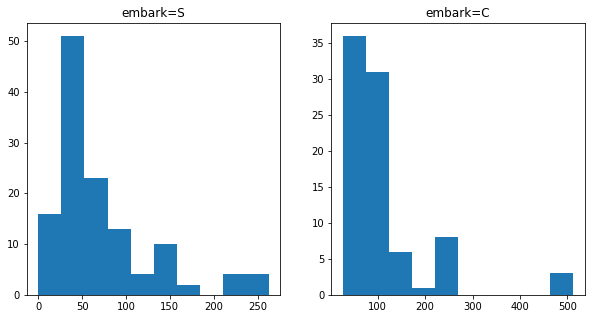

In [8]:
embarked_s = titanic["Embarked"] == "S"
embarked_c = titanic["Embarked"] == "C"
subset_temp2 = titanic[Pclass_1 & embarked_s] 
subset_temp3 = titanic[Pclass_1 & embarked_c] 
# subset_temp2
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(subset_temp2["Fare"])
plt.title("embark=S")

plt.subplot(1,2,2)
plt.hist(subset_temp3["Fare"])
plt.title("embark=C")


From the histograms, we can see that we have higher chance of having Fare=80 with Embark=C. Therefore, we assign C for those missing values.

In [9]:
titanic["Embarked"][61] = "C"
titanic["Embarked"][829] = "C"

In [10]:
print(titanic.count()) # shows total counts for each column

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       891
dtype: int64


For age, let's see how the entries with age=null look like

In [11]:
age_null_idx = titanic[titanic.Age.isnull()].index.tolist() # shows the indices of the missing values
age_null_df = pd.DataFrame(titanic, index=age_null_idx)
age_null_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [59]:
print(sum(age_null_df["Survived"]==1)) 
print(sum(age_null_df["Survived"]==0))

titanic = titanic.drop(age_null_idx, axis=0)
print(titanic.count())


52
125
PassengerId    714
Survived       714
Pclass         714
Name           714
Sex            714
Age            714
SibSp          714
Parch          714
Ticket         714
Fare           714
Cabin          185
Embarked       714
LastName       714
OtherName      714
dtype: int64


Since I cannot think of any way to estimate the age, I decided to eliminate those rows.

### Data processing

Taking the above results into account, we finalize our training set.

Eliminate columns "PassengerID", "Cabin", "Ticket"

Eliminate entries sex=nan

For the categorical variables sex and embarked, we use one-hot encoding.

For name, we take the first letters of the first name and the last name, and then treat them as factors.

It looks like the format of the names is (Last name, Title, First name, Middle name).

First, separate those into three columns (Last name, Title, (First name, Middle name)). To do so, pop the word right to the first comma as the last name, pop the word left to the first full stop as the title, and leave everything else.

In [60]:
lname = [] # store the first letter of the last names
tname = [] # store the titles
oname = [] # store the first letter of the other names
for full_name in titanic["Name"]:
    first_comma = full_name.find(",")
    first_stop = full_name.find(".")
    last_name = full_name[0:first_comma][0]
    name_title = full_name[(first_comma+1):first_stop]
    other_name = full_name[(first_stop+1):len(full_name)][1]
    lname.append(last_name)
    tname.append(name_title)
    oname.append(other_name)


In [61]:
titanic2 = pd.DataFrame(titanic, columns = ["Survived", "Pclass", "Sex", "Age","SibSp","Parch","Fare", "Embarked"])
titanic2["LastName"] = lname
# titanic2["NameTitle"] = tname
titanic2["OtherName"] = oname
titanic2["titles"] = tname

In [63]:
print(titanic2.head())
print(titanic2.count())


   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked LastName  \
0         0       3    male  22.0      1      0   7.2500        S        B   
1         1       1  female  38.0      1      0  71.2833        C        C   
2         1       3  female  26.0      0      0   7.9250        S        H   
3         1       1  female  35.0      1      0  53.1000        S        F   
4         0       3    male  35.0      0      0   8.0500        S        A   

  OtherName titles  
0         O     Mr  
1         J    Mrs  
2         L   Miss  
3         J    Mrs  
4         W     Mr  
Survived     714
Pclass       714
Sex          714
Age          714
SibSp        714
Parch        714
Fare         714
Embarked     714
LastName     714
OtherName    714
titles       714
dtype: int64


The variables that the order does matter is Pclass. So we leave Pclass as it is, and one-hot encode other categorical variables Sex, Embarked, LastName, OtherName, and title.

In [64]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()


In [74]:
sex_oh = pd.get_dummies(titanic2["Sex"], prefix = "Sex")

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
885,1,0
886,0,1
887,1,0
889,0,1
